In [2]:
import pyarrow.parquet as pa 
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import os

In [3]:
table = pa.read_table('../data/part-0.parquet')
df1 = table.to_pandas()
df1['non-wear_flag'].describe()


count    37760.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: non-wear_flag, dtype: float64

In [4]:
df2 = pa.read_table('../data/part-0.parquet').to_pandas()

print(df2.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37760 entries, 0 to 37759
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   step                 37760 non-null  uint32 
 1   X                    37760 non-null  float32
 2   Y                    37760 non-null  float32
 3   Z                    37760 non-null  float32
 4   enmo                 37760 non-null  float32
 5   anglez               37760 non-null  float32
 6   non-wear_flag        37760 non-null  float32
 7   light                37760 non-null  float32
 8   battery_voltage      37760 non-null  float32
 9   time_of_day          37760 non-null  int64  
 10  weekday              37760 non-null  int8   
 11  quarter              37760 non-null  int8   
 12  relative_date_PCIAT  37760 non-null  float32
dtypes: float32(9), int64(1), int8(2), uint32(1)
memory usage: 1.8 MB
None


In [5]:
df2['datetime'] = pd.to_datetime(df2['time_of_day'], unit='ns')
df2['time'] = df2['datetime'].apply(lambda x: x.time()) 

In [6]:
df2['time_of_day'] = df2['time_of_day'] / (10 ** 9) # convert ns to s
df2.head()


,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT,datetime,time
0,0,0.083672,0.271432,0.928594,0.041574,72.262444,0.0,9.0,4172.00,64260.0,5,2,10.0,1970-01-01 17:51:00,17:51:00
1,1,-0.044167,0.185417,0.952292,0.135635,75.381409,0.0,0.0,4172.25,64265.0,5,2,10.0,1970-01-01 17:51:05,17:51:05
2,2,0.343646,0.053802,0.769844,0.107035,57.290592,0.0,7.8,4172.50,64270.0,5,2,10.0,1970-01-01 17:51:10,17:51:10
3,3,0.114870,0.156953,0.770130,0.128197,63.518497,0.0,15.6,4172.75,64275.0,5,2,10.0,1970-01-01 17:51:15,17:51:15
4,4,0.130990,0.292057,0.708672,0.045588,50.506268,0.0,23.4,4173.00,64280.0,5,2,10.0,1970-01-01 17:51:20,17:51:20


<Axes: >

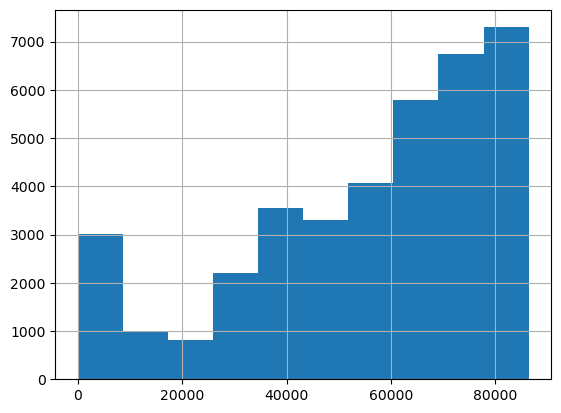

In [7]:
df2['time_of_day'].hist()

<Axes: >

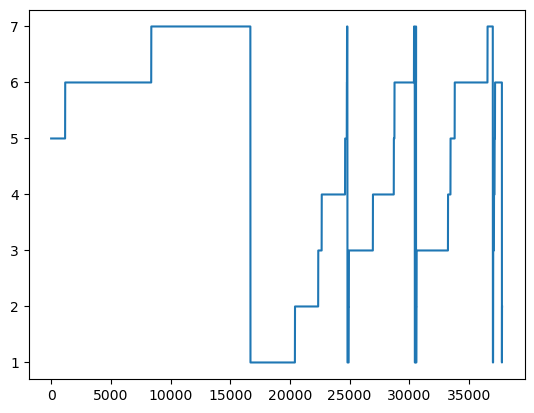

In [8]:
df2['weekday'].plot()

<Axes: >

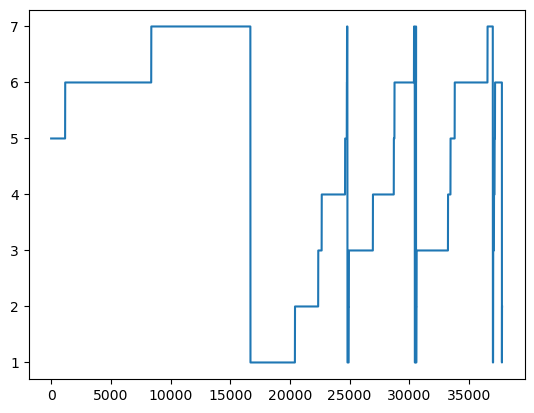

In [9]:
df1['weekday'].plot()

<Axes: >

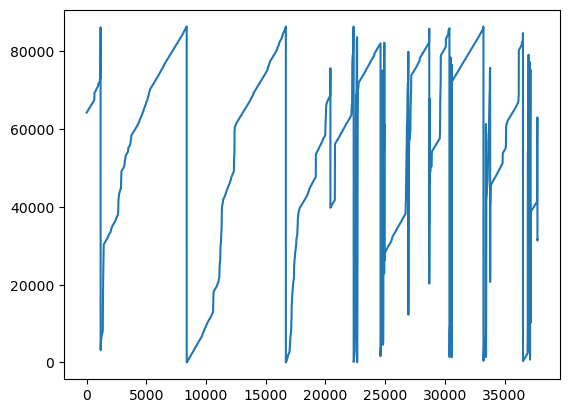

In [10]:
df2['time_of_day'].plot()

In [11]:
df2['time_of_day'] = df2['time_of_day'] / (10 ** 9) # convert ns to s

In [12]:
# 1) Detect day changes
df2['day_change'] = df2['weekday'].ne(df2['weekday'].shift(1))
# Explanation: 
#   .shift(1) looks at the previous row’s day_of_week
#   .ne(...) means "not equal" (True if they differ, False if they’re equal)

# 2) Build a day_number by taking the cumulative sum of these changes.
#    We fill missing values for the first row with False and then add 1.
df2['day_change'] = df2['day_change'].fillna(False)
df2['day_number'] = df2['day_change'].cumsum() + 1

# Now df['day_number'] goes from 1 up to the total count of days (e.g. 30).

# 3) Compute the mean of 'light' for each calendar day
daily_mean_light = df2.groupby('day_number')['weekday']
df_daily = df2.groupby('day_number')['light'].mean()

day_map = (
    df2
    .groupby('day_number')['weekday']
    .first()  # Or .unique() if you like
    .reset_index()
)

print(day_map)
# Reindex the daily data to days 1..30
df_daily = df_daily.reindex(range(1, 31))


    day_number  weekday
0            2        5
1            3        6
2            4        7
3            5        1
4            6        2
5            7        3
6            8        4
7            9        5
8           10        6
9           11        7
10          12        1
11          13        2
12          14        3
13          15        4
14          16        5
15          17        6
16          18        7
17          19        1
18          20        2
19          21        3
20          22        6
21          23        7
22          24        1
23          25        2
24          26        3
25          27        4
26          28        5
27          29        6
28          30        7
29          31        1
30          32        2
31          33        3
32          34        4
33          35        5
34          36        6
35          37        1
36          38        2


In [13]:
temp30 = np.arange(1, 31, 1)
print(temp30)
print(temp30.shape)
month = pd.DataFrame(temp30, columns=['day_number'])
month['weekday'] = (month['day_number']+3) % 7 + 1
print(month)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
(30,)
    day_number  weekday
0            1        5
1            2        6
2            3        7
3            4        1
4            5        2
5            6        3
6            7        4
7            8        5
8            9        6
9           10        7
10          11        1
11          12        2
12          13        3
13          14        4
14          15        5
15          16        6
16          17        7
17          18        1
18          19        2
19          20        3
20          21        4
21          22        5
22          23        6
23          24        7
24          25        1
25          26        2
26          27        3
27          28        4
28          29        5
29          30        6


In [14]:
print(month.join(day_map, on='day_number', how='left', rsuffix='_r_'))

    day_number  weekday  day_number_r_  weekday_r_
0            1        5              3           6
1            2        6              4           7
2            3        7              5           1
3            4        1              6           2
4            5        2              7           3
5            6        3              8           4
6            7        4              9           5
7            8        5             10           6
8            9        6             11           7
9           10        7             12           1
10          11        1             13           2
11          12        2             14           3
12          13        3             15           4
13          14        4             16           5
14          15        5             17           6
15          16        6             18           7
16          17        7             19           1
17          18        1             20           2
18          19        2        

<Axes: >

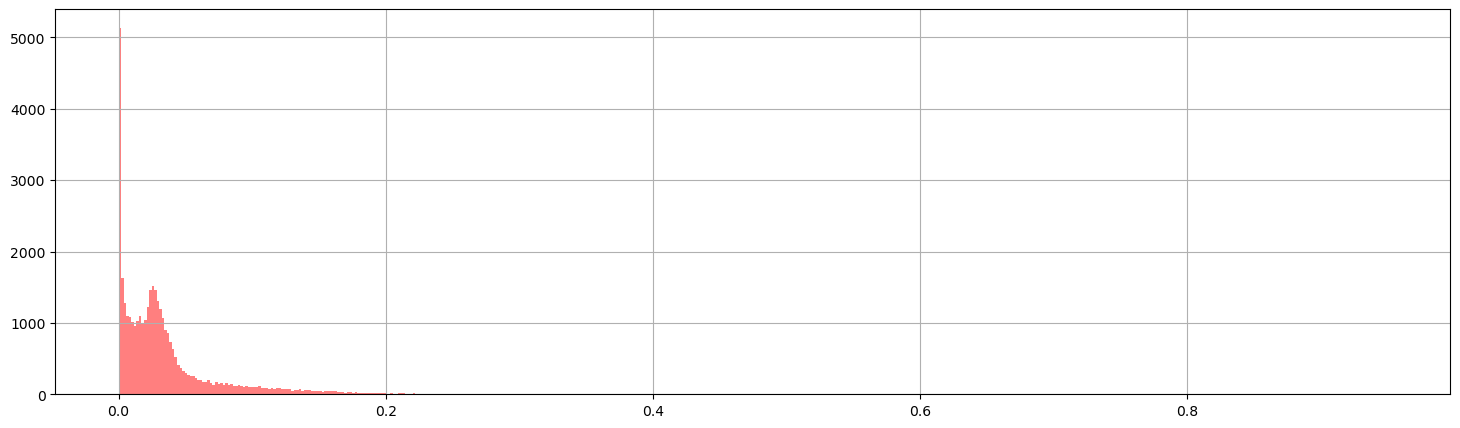

In [15]:
df2.enmo.hist(figsize=(18,5), bins=500, color='red', alpha=0.5)

# Read folder of parquets: 

In [ ]:
def process_dataframe(df: DataFrame) -> DataFrame:

    # convert ns to s
    df['time_of_day'] = df['time_of_day'] / (10 ** 9) # convert ns to s

    # get day number for aggregation

def get_clean_df(df: DataFrame, item_id:str) -> DataFrame:
    # add 'day_number' to dataframe
    # add 'user_id to dataframe
    # drop 'non-wear_flag' == 1

    df_temp = df.copy()
    df_temp['day_change'] = df_temp['weekday'].ne(df_temp['weekday'].shift(1))
    # Explanation: 
    #   .shift(1) looks at the previous row’s day_of_week
    #   .ne(...) means "not equal" (True if they differ, False if they’re equal)

    # 2) Build a day_number by taking the cumulative sum of these changes.
    #    We fill missing values for the first row with False and then add 1.
    df_temp['day_change'] = df_temp['day_change'].fillna(False)
    df_temp['day_number'] = df_temp['day_change'].cumsum()

    df_temp['user_id'] = item_id
    df_temp = df_temp[df_temp['non-wear_flag'] == 0]
    
    return df_temp


enmo_thresholds=  (0.0563, 0.1916, 0.6958) # inactive, light, moderate, and vigorous

def approximate_steps(enmo: float) -> int:
    if enmo < enmo_thresholds[0]:
        return 0
    elif enmo < enmo_thresholds[1]:
        return 1
    elif enmo < enmo_thresholds[2]:
        return 3
    else:
        return 5

# get daily light and steps
def get_daily_light_and_steps(df: DataFrame) -> DataFrame:
    df_copy = df.copy()
    df_copy['enmo_steps'] = df_copy['enmo'].apply(approximate_steps)
    df_daily_light = pd.DataFrame(df_copy.groupby(['day_number','weekday'], as_index=False)
                                  .aggregate({'light': 'mean', 'enmo_steps': 'sum', 'quarter': 'first'})
                                .rename(columns={'light': 'daily_light_mean', 'enmo_steps': 'daily_steps'}))

    return df_daily_light

def get_daily_steps(df: DataFrame) -> DataFrame:
    df_daily_steps = pd.DataFrame(df.groupby(['day_number','weekday'])['enmo'].sum())
    return df_daily_steps



In [17]:
def read_parquet_files(data_directory='data') -> DataFrame:
    
    data_dir = data_directory
    steps_light_df = pd.DataFrame()
    print(len(os.listdir(data_dir)))
    for item_name in os.listdir(data_dir):
        item_path = os.path.join(data_dir, item_name)

        if os.path.isdir(item_path) and item_name.startswith("id="):
            item_id = item_name.split("=")[1]
            parquet_file_path = os.path.join(item_path, 'part-0.parquet')
            
            if os.path.exists(parquet_file_path):
                # print(f"Now processing: {parquet_file_path}")
                
                df = pd.read_parquet(parquet_file_path)
                df = get_clean_df(df, item_id=item_id)
                
                # print(df.head())
                daily_lights = get_daily_light_and_steps(df)
                # print(daily_lights.shape)
                daily_lights['user_id'] = item_id
                # print(daily_lights)
                steps_light_df = pd.concat([steps_light_df, daily_lights])
                
                del df
    return steps_light_df

# result = read_parquet_files(data_directory='data')
# print(result.shape)
# print(result)
# result.to_csv('steps_light.csv', index=True)


In [18]:
band_data_dir = '../data/raw_band_data'

all_dfs = pd.DataFrame()

for folder_name in os.listdir(band_data_dir):
    if folder_name.startswith('data'):
        folder_path = os.path.join(band_data_dir, folder_name)
        print(folder_path)
        if os.path.isdir(folder_path):
            folder_dfs = read_parquet_files(data_directory=folder_path)
            all_dfs = pd.concat([all_dfs, folder_dfs])

print(all_dfs.shape)    
all_dfs.to_csv('../data/all_data_steps_light.csv')


../data/raw_band_data/data1
360
../data/raw_band_data/data2
304
../data/raw_band_data/data3
296
../data/raw_band_data/data4
37
(25763, 6)


In [22]:
all_dfs['user_id'].unique().size

996

<Axes: >

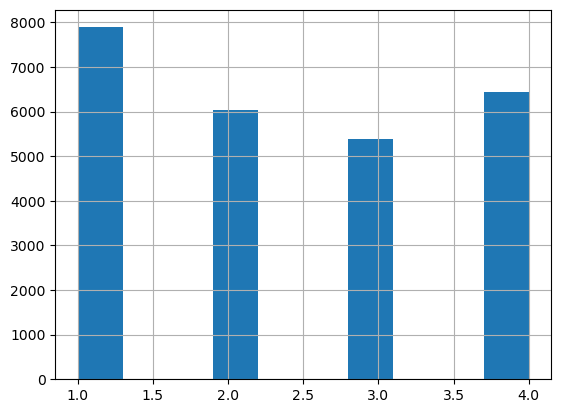

In [20]:
all_dfs['quarter'].hist()

# Compute Steps based on Activity Level: 

In [21]:
enmo_thresholds=  (0.0563, 0.1916, 0.6958) # inactive, light, moderate, and vigorous

def approximate_steps(enmo: float) -> int:
    if enmo < enmo_thresholds[0]:
        return 0
    elif enmo < enmo_thresholds[1]:
        return 1
    elif enmo < enmo_thresholds[2]:
        return 3
    else:
        return 5

def get_daily_steps(df: DataFrame) -> DataFrame:
    df_copy = df.copy()
    df_copy['enmo_steps'] = df_copy['enmo'].apply(approximate_steps)
    df_daily_steps = pd.DataFrame(df_copy.groupby(['day_number','weekday'])['enmo_steps'].sum())
    return df_daily_steps


In [25]:
# compare the two steps: 

without_enmo = pd.read_csv('../data/all_data_steps_without_enmo.csv')
with_enmo = pd.read_csv('../data/all_data_steps_light.csv')

print(with_enmo.daily_steps.describe())
print(without_enmo.daily_steps.describe())

count    25763.000000
mean      2547.844583
std       2541.293862
min          0.000000
25%         11.000000
50%       2081.000000
75%       4421.000000
max      14771.000000
Name: daily_steps, dtype: float64
count    25763.000000
mean       393.531273
std        382.779633
min          0.000000
25%         13.045191
50%        346.292000
75%        658.574520
max       4555.529000
Name: daily_steps, dtype: float64
